<a href="https://colab.research.google.com/github/kanyakornvee/CWT/blob/main/Pycaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret
!pip install pycaret-ts-alpha

     |████████████████████████████████| 498 kB 7.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.9 MB/s 
     |████████████████████████████████| 9.5 MB 19.1 MB/s 
     |████████████████████████████████| 1.4 MB 39.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 6.2 MB 39.3 MB/s 
     |████████████████████████████████| 14.9 MB 42.1 MB/s 
     |████████████████████████████████| 9.5 MB 25.0 MB/s 
     |████████████████████████████████| 3.3 MB 56.6 MB/s 
     |████████████████████████████████| 34.5 MB 4.7 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0

# Clean Data

In [252]:
import pandas as pd
df = pd.read_csv('/content/CWT/provider_level_data.csv')
df.rename({'period': 'time'}, axis=1, inplace=True)
df['performance'] = round(df['performance']*100, 2)
df = df[df.cancer_type == "ALL CANCERS"]
df = df.drop(["cancer_type", "provider_name", "provider_code", "total_treated",
              "within_standard", "breaches", "standard" ], axis=1)
df['time']= pd.to_datetime(df['time'])
df['region_name'].fillna("Unknown", inplace = True)
df['region_name'] = pd.Categorical(df['region_name'],
                                   categories=["Unknown",
                                               "LONDON COMMISSIONING REGION",
                                               "MIDLANDS AND EAST OF ENGLAND COMMISSIONING REGION",
                                               "NORTH OF ENGLAND COMMISSIONING REGION",
                                               "SOUTH OF ENGLAND COMMISSIONING REGION"],ordered=True)
df['month'] = [i.month for i in df['time']]
df['year'] = [i.year for i in df['time']]
df1 = df[(df.time >= '2016-1-1') & (df.time < '2020-3-1')]

In [253]:
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105970 entries, 3324 to 560400
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         105970 non-null  datetime64[ns]
 1   region_name  105970 non-null  category      
 2   performance  105970 non-null  float64       
 3   month        105970 non-null  int64         
 4   year         105970 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 4.1 MB


,time,region_name,performance,month,year
3324,2016-01-01,Unknown,100.00,1,2016
3326,2016-01-01,Unknown,77.42,1,2016
3327,2016-01-01,Unknown,0.00,1,2016
3328,2016-01-01,Unknown,100.00,1,2016
3332,2016-01-01,Unknown,100.00,1,2016


In [254]:
#Divided by region
df_un_pre = df1[df1.region_name == "Unknown"]
df_lon_pre = df1[df1.region_name == "LONDON COMMISSIONING REGION"]
df_mid_pre = df1[df1.region_name == "MIDLANDS AND EAST OF ENGLAND COMMISSIONING REGION"]
df_nor_pre = df1[df1.region_name == "NORTH OF ENGLAND COMMISSIONING REGION"]
df_sou_pre = df1[df1.region_name == "SOUTH OF ENGLAND COMMISSIONING REGION"]

In [255]:
#Drop region column so the df will be left with x and y column for univariate analysis
df_un_pre = df_un_pre.drop(["region_name"], axis=1)
df_lon_pre = df_lon_pre.drop(["region_name"], axis=1)
df_mid_pre = df_mid_pre.drop(["region_name"], axis=1)
df_nor_pre = df_nor_pre.drop(["region_name"], axis=1)
df_sou_pre = df_sou_pre.drop(["region_name"], axis=1)

#Set time as index
df_un_pre.set_index('time', inplace=True)
df_lon_pre.set_index('time', inplace=True)
df_mid_pre.set_index('time', inplace=True)
df_nor_pre.set_index('time', inplace=True)
df_sou_pre.set_index('time', inplace=True)

In [256]:
df_un_pre.head()

,performance,month,year
time,,,
2016-01-01,100.00,1,2016
2016-01-01,77.42,1,2016
2016-01-01,0.00,1,2016
2016-01-01,100.00,1,2016
2016-01-01,100.00,1,2016


In [284]:
#Create df contains performance across UK WITH MEAN PERFORMANCE
#The analysis does not work with multiple y in one x
df_UK_pre = df1.groupby(["time"]).mean()
df_UK_pre.columns = ['mean performance','month','year']
df_UK_pre = df_UK_pre.reset_index()

#Create test & train data across UK
df_UK_pre_train = df_UK_pre[(df_UK_pre.time < '2019-12-1')]
df_UK_pre_test = df_UK_pre[(df_UK_pre.time >= '2019-12-1')]

#Re-indexing
df_UK_pre = df_UK_pre.set_index('time')
df_UK_pre.head()

,mean performance,month,year
time,,,
2016-01-01,89.478841,1,2016
2016-02-01,89.294764,2,2016
2016-03-01,91.302590,3,2016
2016-04-01,89.551194,4,2016
2016-05-01,89.678592,5,2016


# Pycaret Time Series Analysis

In [154]:
#from pycaret.time_series import *
#exp_UK = setup(data = df_UK,  fh = 12)

,Description,Value
0,session_id,6457
1,Original Data,"(71, 1)"
2,Missing Values,False
3,Transformed Train Set,"(59,)"
4,Transformed Test Set,"(12,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,12
9,Seasonality Detected,False


In [287]:
# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = df_UK_pre_train, test_data = df_UK_pre_test, target = 'mean performance', fold_strategy = 'timeseries',
          numeric_features = ['year','month'], fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,mean performance
2,Original Data,"(47, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(47, 23)"


In [288]:
best_UK = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.9775,2.1882,1.0923,-0.7417,0.0122,0.0112,0.0233
lr,Linear Regression,1.1165,2.4918,1.2128,-1.1282,0.0135,0.0127,0.0200
lasso,Lasso Regression,1.1452,3.2340,1.2816,-1.2678,0.0143,0.0131,0.0233
en,Elastic Net,1.1664,3.3382,1.3000,-1.3247,0.0145,0.0134,0.0200
omp,Orthogonal Matching Pursuit,1.4059,3.7071,1.6031,-1.4394,0.0180,0.0162,0.0233
br,Bayesian Ridge,1.4272,3.2254,1.6289,-1.5457,0.0183,0.0164,0.0200
rf,Random Forest Regressor,1.7284,4.5145,1.9625,-3.5826,0.0221,0.0200,0.2567
gbr,Gradient Boosting Regressor,1.8253,5.0284,2.1084,-4.1967,0.0237,0.0211,0.0467
et,Extra Trees Regressor,1.8517,5.1339,2.1129,-4.2410,0.0237,0.0214,0.1900
dt,Decision Tree Regressor,1.8601,5.1927,2.1564,-4.4547,0.0242,0.0215,0.0233


In [289]:
#Lasso Regression has lowest MAE from assignment methods followed by Random Forest Regressor
#Create visualization for prediction
future_dates = pd.date_range(start = '2020-3-1', end = '2024-1-1', freq = 'MS')
future_df = pd.DataFrame()
future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates] 
future_df['time'] = future_dates 


las_m_UK = create_model('lasso')
pred_las_m_UK = predict_model(las_m_UK, data = future_df)

rf_m_UK = create_model('rf')
pred_rf_m_UK = predict_model(rf_m_UK, data = future_df)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6301,0.6871,0.8289,-0.1340,0.0091,0.0071
1,2.4548,7.3170,2.7050,-2.7615,0.0304,0.0283
2,2.1004,5.5393,2.3536,-7.8522,0.0269,0.0247
Mean,1.7284,4.5145,1.9625,-3.5826,0.0221,0.0200
SD,0.7900,2.8020,0.8143,3.2040,0.0093,0.0093


In [187]:
! pip install plotly
import plotly.express as px

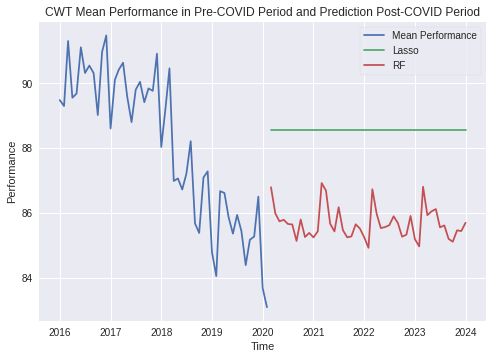

In [292]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig_UK, ax = plt.subplots()
plt.plot(df_UK_pre.index, df_UK_pre['mean performance'], label = "Mean Performance")
plt.plot(pred_las_m_UK['time'], pred_las_m_UK['Label'], label = "Lasso")
plt.plot(pred_rf_m_UK['time'], pred_rf_m_UK['Label'], label = "RF")
ax.set_title('CWT Mean Performance in Pre-COVID Period and Prediction Post-COVID Period')
ax.set_xlabel('Time')
ax.set_ylabel('Performance')
plt.legend(frameon=True)
plt.show()

fig_UK.savefig('Across UK Prediction', bbox_inches = 'tight')

In [220]:
df_UK_pre

,performance,month,year
time,,,
2016-01-01,89.478841,1,2016
2016-02-01,89.294764,2,2016
2016-03-01,91.302590,3,2016
2016-04-01,89.551194,4,2016
2016-05-01,89.678592,5,2016
...,...,...,...
2021-07-01,80.575485,7,2021
2021-08-01,79.881249,8,2021
2021-09-01,77.884185,9,2021


In [217]:
concat_rf_UK = pd.concat([df_UK_pre, pred_rf_m_UK], axis=0)
concat_rf_UK.set_index('time', inplace=True)
fig_rf_UK = px.line(concat_rf_UK, x = concat_rf_UK.index, y=["performance", "Label"])
fig_rf_UK.show()